In [1]:
!pip install shap

### Import the necessary Libraries

In [1]:
import pandas as pd
import numpy as  np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

pd.options.display.max_columns = 500
import warnings
warnings.filterwarnings('ignore')

import shap

# print the JS visualization code to the notebook
shap.initjs()

/home/adeptschneiderthedev/.miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
train_df = pd.read_csv("Train.csv")
sample_submission = pd.read_csv("SampleSubmission.csv")

train_df.shape, sample_submission.shape

((289926, 19), (370, 2))

In [3]:
train_df.head()

,impressions,clicks,cost,conversions,ad_type,currency,ID,date,call_type,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
0,142.0,15.0,3393.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,5.0,11.0
1,89.0,8.0,1817.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,13.0
2,59.0,8.0,1743.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,10.0
3,78.0,4.0,917.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,3.0,13.0
4,20.0,1.0,217.0,0.0,EXPANDED_TEXT_AD,ZAR,ID_5da86e71bf5dee4cf5047046,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,16.279669,0.0,2.0,2.0,13.0


In [4]:
train_df.tail()

,impressions,clicks,cost,conversions,ad_type,currency,ID,date,call_type,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
289921,NaN,NaN,NaN,NaN,NaN,NaN,ID_65687e2b40ea026fcc662a75,2024-02-03,NaN,NaN,NaN,NaN,NaN,NaN,12.035682,0.0,NaN,NaN,NaN
289922,NaN,NaN,NaN,NaN,NaN,NaN,ID_65687e2b40ea026fcc662a75,2024-02-04,NaN,NaN,NaN,NaN,NaN,NaN,15.711023,0.0,NaN,NaN,NaN
289923,NaN,NaN,NaN,NaN,NaN,NaN,ID_65a7bf329fa4627faf28390c,2024-02-03,NaN,NaN,NaN,NaN,NaN,NaN,15.464425,0.0,NaN,NaN,NaN
289924,NaN,NaN,NaN,NaN,NaN,NaN,ID_65b0f65c7fe62e56c5593d55,2024-02-03,NaN,NaN,NaN,NaN,NaN,NaN,10.016481,0.0,NaN,NaN,NaN
289925,NaN,NaN,NaN,NaN,NaN,NaN,ID_65b0f65c7fe62e56c5593d55,2024-02-04,NaN,NaN,NaN,NaN,NaN,NaN,9.990000,0.0,NaN,NaN,NaN


In [5]:
train_df.shape

(289926, 19)

In [6]:
sample_submission.head()

,ID,clicks
0,ID_5da86e71bf5dee4cf5047046_2024_01_22,0
1,ID_5da86e71bf5dee4cf5047046_2024_01_29,0
2,ID_5e43c29e6279884e2827d894_2024_02_21,0
3,ID_5e43c29e6279884e2827d894_2024_02_28,0
4,ID_5e4e7b480e374330ee151305_2023_12_04,0


In [7]:
sample_submission.tail()

,ID,clicks
365,ID_6568807cbb9c4d235c5dd9a8_2024_02_06,0
366,ID_65a7bf329fa4627faf28390c_2024_02_21,0
367,ID_65a7bf329fa4627faf28390c_2024_02_28,0
368,ID_65b0f65c7fe62e56c5593d55_2024_02_21,0
369,ID_65b0f65c7fe62e56c5593d55_2024_02_28,0


### Remove NaN values from the dataset

In [8]:
def remove_nans(data, thresh):
    def nans_rate(data, col):
        return data[col].isna().sum() / data.shape[0]
    
    for col in data.columns:
        if nans_rate(data, col) >= thresh:
            data.drop(col, axis=1, inplace=True)
            
    return data

train = remove_nans(train_df, 0.7)
train.shape

(289926, 13)

### Drop the currency column and sort the dataset by the 'ID' and 'Date' column
- The 'currency' column is dropped because it is not significant in the time series modeling of the dataset

In [9]:
train.drop(columns = ['currency'], inplace=True)
train.sort_values(by = ['ID', 'date'], inplace=True)

In [10]:
train.head()

,impressions,clicks,cost,conversions,ad_type,ID,date,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
0,142.0,15.0,3393.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2020-01-01,16.279669,0.0,2.0,5.0,11.0
1,89.0,8.0,1817.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2020-01-01,16.279669,0.0,2.0,2.0,13.0
2,59.0,8.0,1743.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2020-01-01,16.279669,0.0,2.0,2.0,10.0
3,78.0,4.0,917.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2020-01-01,16.279669,0.0,2.0,3.0,13.0
4,20.0,1.0,217.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2020-01-01,16.279669,0.0,2.0,2.0,13.0


In [11]:
train.tail()

,impressions,clicks,cost,conversions,ad_type,ID,date,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
289521,299.0,29.0,6809.716151,0.0,RESPONSIVE_SEARCH_AD,ID_65b0f65c7fe62e56c5593d55,2024-02-13,9.99,0.0,1.0,5.0,13.0
289522,410.0,28.0,6598.474957,0.0,RESPONSIVE_SEARCH_AD,ID_65b0f65c7fe62e56c5593d55,2024-02-13,9.99,0.0,1.0,4.0,16.0
289523,281.0,11.0,3642.348176,0.0,RESPONSIVE_SEARCH_AD,ID_65b0f65c7fe62e56c5593d55,2024-02-13,9.99,0.0,1.0,4.0,14.0
289524,41.0,5.0,547.477180,0.0,EXPANDED_DYNAMIC_SEARCH_AD,ID_65b0f65c7fe62e56c5593d55,2024-02-13,9.99,0.0,0.0,0.0,0.0
289525,77.0,1.0,394.983536,0.0,RESPONSIVE_SEARCH_AD,ID_65b0f65c7fe62e56c5593d55,2024-02-13,9.99,0.0,1.0,4.0,13.0


### Feature Engineering

In [12]:
import re

def extract_parts(value):
    match = re.match(r'([^_]*_[^_]*)_?(.*)', value)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Function to determine the week of the month
def week_of_month(date_val):
    first_day = date_val.replace(day=1)
    day_of_month = date_val.day
    adjusted_dom = day_of_month + first_day.weekday()
    return int(np.ceil(adjusted_dom / 7))

# Main function to build datasets
def build_datasets(train, sub, client_id):
    # Extract the minimum date in the submission dataset for the client ID
    min_date_sub = sub[sub['ID'].str.contains(client_id)]['ID'].apply(lambda x: '_'.join(x.split('_')[-3:])).min()
    min_date_sub = pd.to_datetime(min_date_sub, format='%Y_%m_%d')

    # Subset the training data for the client ID
    train_subset = train[train['ID'] == client_id]
    max_date_train = pd.to_datetime(train_subset['date']).max()

    # Generate missing dates between the max training date and the min submission date
    missing_dates = pd.date_range(start=max_date_train + pd.Timedelta(days=1), end=min_date_sub - pd.Timedelta(days=1), freq='D')
    missing_rows = pd.DataFrame({'date': missing_dates, 'ID': client_id})
    train_with_missing = pd.concat([train_subset, missing_rows], ignore_index=True)
    train_with_missing['identifier'] = 'train'

    # Add identifier to the submission data
    sub['identifier'] = 'test'

    # Convert 'date' column to datetime
    train_with_missing['date'] = pd.to_datetime(train_with_missing['date'])
    
    # Create a complete date range and merge with training data
    date_range = pd.date_range(start=train_with_missing['date'].min(), end=train_with_missing['date'].max())
    all_dates = pd.DataFrame({'date': date_range, 'ID': client_id})
    merged_df = pd.merge(all_dates, train_with_missing, on=['date', 'ID'], how='left')
    merged_df['identifier'].fillna('train', inplace=True)
    merged_df['unique_id'] = merged_df['ID'].astype(str) + "_" + merged_df['date'].dt.strftime('%Y-%m-%d')

    # Process the submission data
    sub_ = sub[sub['ID'].str.contains(client_id)].copy()
    sub_['ID'], sub_['date'] = zip(*sub_['ID'].apply(extract_parts))
    sub_['date'] = pd.to_datetime(sub_['date'], format='%Y_%m_%d')

    # Concatenate training and submission data
    concatenated_df = pd.concat([merged_df, sub_], ignore_index=True)
    concatenated_df['date'] = pd.to_datetime(concatenated_df['date'])

    # Extract date-related features
    concatenated_df['day'] = concatenated_df['date'].dt.day
    concatenated_df['year'] = concatenated_df['date'].dt.year
    concatenated_df['week'] = concatenated_df['date'].dt.isocalendar().week
    concatenated_df['month'] = concatenated_df['date'].dt.month
    concatenated_df['is_weekend'] = concatenated_df['date'].dt.dayofweek >= 5
    concatenated_df['day_of_week'] = concatenated_df['date'].dt.dayofweek
    concatenated_df['week_of_month'] = concatenated_df['date'].apply(week_of_month)
    concatenated_df['is_month_start'] = concatenated_df.date.dt.is_month_start.astype(int)
    concatenated_df['is_month_end'] = concatenated_df.date.dt.is_month_end.astype(int)
    concatenated_df['quarter_of_year'] = concatenated_df.date.dt.quarter
    concatenated_df['day_of_year'] = concatenated_df.date.dt.dayofyear

    # Aggregate the data by date
    df_agg = concatenated_df.groupby('date').agg({
        'impressions': 'sum',
        'clicks': 'sum',
        'ad_type': 'first',
        'ID': 'first',
        'day': 'first',
        'year': 'first',
        'week': 'first',
        'month': 'first',
        'is_weekend': 'first',
        'week_of_month': 'first',
        'quarter_of_year': 'first',
        'day_of_year': 'first',
        'is_month_start': 'first',
        'is_month_end': 'first',
        'identifier': 'first'
    }).reset_index()

    # Aggregate data by month and week
    df_month = concatenated_df.groupby(['month']).agg({
        'impressions': ['mean', 'std', 'min', 'max', 'skew'],
        'cost': ['mean', 'std', 'min', 'max', 'skew']
    }).reset_index()
    df_month.columns = ['month'] + [f"month_{col}_{stat}" for col, stat in df_month.columns[1:]]

    df_weekly = concatenated_df.groupby('week').agg({
        'impressions': ['mean', 'std', 'min', 'max', 'skew'],
        'cost': ['mean', 'std', 'min', 'max', 'skew']
    }).reset_index()
    df_weekly.columns = ['week'] + [f"weekly_{col}_{stat}" for col, stat in df_weekly.columns[1:]]

    # Merge aggregated data back into the main dataframe
    df_agg = pd.merge(df_agg, df_month, on='month', how='left')
    df_agg = pd.merge(df_agg, df_weekly, on='week', how='left')

    # Label encode categorical columns
    le = LabelEncoder()
    for col in ['ad_type']:
        df_agg[col] = le.fit_transform(df_agg[col])

    # Create lagged features
    def create_lagged_features(df, cols, shifts):
        for col in cols:
            for shift in shifts:
                df[f"lagged_{col}_{shift}"] = df[col].shift(shift)
        return df

    def create_diff_features(df, cols, shifts):
        for col in cols:
            for shift in shifts:
                df[f"diff_{col}_lagged_{shift}"] = df[f"lagged_{col}_{shifts[0]}"] - df[f"lagged_{col}_{shift}"]
        return df

    lag_cols = [col for col in df_agg.columns if col not in ['date', 'ID', 'ad_type', 'unique_id', 'is_weekend', 'week_of_month', 'quarter_of_year', 'day_of_year', 'is_month_start', 'is_month_end', 'day', 'year', 'week', 'month', 'identifier']]
    stats_cols = [col for col in df_agg.columns if any(substring in col for substring in ['mean', 'std', 'min', 'max', 'skew'])]

    df_agg = create_lagged_features(df_agg, lag_cols, range(15, 23))
    df_agg = create_lagged_features(df_agg, stats_cols, [15, 23, 30])
    df_agg = create_diff_features(df_agg, lag_cols, range(16, 23))
    df_agg = create_diff_features(df_agg, stats_cols, [23, 30])

    # Select independent features
    date_cols = ['is_weekend', 'week_of_month', 'quarter_of_year', 'day_of_year', 'is_month_start', 'is_month_end', 'day', 'year', 'week', 'month']
    independent_features = [col for col in df_agg.columns if 'lagged' in col] + date_cols + [col for col in df_agg.columns if 'roll_mean' in col]

    # Filter the aggregated dataframe to include only relevant columns
    df_agg = df_agg[['clicks', 'identifier', 'date', 'ID'] + independent_features + stats_cols]
    df_agg['unique_id'] = df_agg['ID'].astype(str) + "_" + df_agg['date'].dt.strftime('%Y-%m-%d')

    # Separate training and testing data
    df_agg_train = df_agg[df_agg['identifier'] == 'train']
    df_agg_test = df_agg[df_agg['identifier'] == 'test']

    # Create a sampled training dataset
    selected_rows = []
    counter = 0
    for i in range(len(df_agg_train) - 1, -1, -1):
        counter += 1
        if counter in [8, 15]:
            selected_rows.append(df_agg_train.iloc[i])
        if counter == 15:
            counter = 0
    train_df = pd.DataFrame(selected_rows)

    return train_df, df_agg_test

In [13]:
all_train_sets = []
all_test_sets = []
for agent_id in tqdm(train['ID'].unique()):
    train_set, test_set = build_datasets(train, sample_submission, agent_id)
    all_train_sets.append(train_set)
    all_test_sets.append(test_set)
print(len(all_train_sets), len(all_test_sets))

  0%|          | 0/185 [00:00<?, ?it/s]

100%|██████████| 185/185 [01:06<00:00,  2.77it/s]

185 185


In [14]:
final_train_df = pd.concat(all_train_sets)
final_test_df = pd.concat(all_test_sets)
final_train_df['ID'] = le.fit_transform(final_train_df['ID'])
final_test_df['ID'] = le.transform(final_test_df['ID'])

In [15]:
stats_cols = [col for col in final_train_df.columns if any(substring in col for substring in ['mean', 'std', 'min', 'max', 'skew'])]
date_cols = [ 'is_weekend', 'week_of_month', 'quarter_of_year', 'day_of_year',
       'is_month_start', 'is_month_end', 'day', 'year', 'week', 'month' ]
independent_features =  [col for col in final_train_df.columns if 'lagged' in col] + ['ID']+ date_cols + [col for col in stats_cols if 'lagged' not in col] + [col for col in final_train_df.columns if 'roll_mean' in col]

In [16]:
final_train_df

,clicks,identifier,date,ID,lagged_impressions_15,lagged_impressions_16,lagged_impressions_17,lagged_impressions_18,lagged_impressions_19,lagged_impressions_20,lagged_impressions_21,lagged_impressions_22,lagged_clicks_15,lagged_clicks_16,lagged_clicks_17,lagged_clicks_18,lagged_clicks_19,lagged_clicks_20,lagged_clicks_21,lagged_clicks_22,lagged_month_impressions_mean_15,lagged_month_impressions_mean_16,lagged_month_impressions_mean_17,lagged_month_impressions_mean_18,lagged_month_impressions_mean_19,lagged_month_impressions_mean_20,lagged_month_impressions_mean_21,lagged_month_impressions_mean_22,lagged_month_impressions_std_15,lagged_month_impressions_std_16,lagged_month_impressions_std_17,lagged_month_impressions_std_18,lagged_month_impressions_std_19,lagged_month_impressions_std_20,lagged_month_impressions_std_21,lagged_month_impressions_std_22,lagged_month_impressions_min_15,lagged_month_impressions_min_16,lagged_month_impressions_min_17,lagged_month_impressions_min_18,lagged_month_impressions_min_19,lagged_month_impressions_min_20,lagged_month_impressions_min_21,lagged_month_impressions_min_22,lagged_month_impressions_max_15,lagged_month_impressions_max_16,lagged_month_impressions_max_17,lagged_month_impressions_max_18,lagged_month_impressions_max_19,lagged_month_impressions_max_20,lagged_month_impressions_max_21,lagged_month_impressions_max_22,lagged_month_impressions_skew_15,lagged_month_impressions_skew_16,lagged_month_impressions_skew_17,lagged_month_impressions_skew_18,lagged_month_impressions_skew_19,lagged_month_impressions_skew_20,lagged_month_impressions_skew_21,lagged_month_impressions_skew_22,lagged_month_cost_mean_15,lagged_month_cost_mean_16,lagged_month_cost_mean_17,lagged_month_cost_mean_18,lagged_month_cost_mean_19,lagged_month_cost_mean_20,lagged_month_cost_mean_21,lagged_month_cost_mean_22,lagged_month_cost_std_15,lagged_month_cost_std_16,lagged_month_cost_std_17,lagged_month_cost_std_18,lagged_month_cost_std_19,lagged_month_cost_std_20,lagged_month_cost_std_21,lagged_month_cost_std_22,lagged_month_cost_min_15,lagged_month_cost_min_16,lagged_month_cost_min_17,lagged_month_cost_min_18,lagged_month_cost_min_19,lagged_month_cost_min_20,lagged_month_cost_min_21,lagged_month_cost_min_22,lagged_month_cost_max_15,lagged_month_cost_max_16,lagged_month_cost_max_17,lagged_month_cost_max_18,lagged_month_cost_max_19,lagged_month_cost_max_20,lagged_month_cost_max_21,lagged_month_cost_max_22,lagged_month_cost_skew_15,lagged_month_cost_skew_16,lagged_month_cost_skew_17,lagged_month_cost_skew_18,lagged_month_cost_skew_19,lagged_month_cost_skew_20,lagged_month_cost_skew_21,lagged_month_cost_skew_22,lagged_weekly_impressions_mean_15,lagged_weekly_impressions_mean_16,lagged_weekly_impressions_mean_17,lagged_weekly_impressions_mean_18,lagged_weekly_impressions_mean_19,lagged_weekly_impressions_mean_20,lagged_weekly_impressions_mean_21,lagged_weekly_impressions_mean_22,lagged_weekly_impressions_std_15,lagged_weekly_impressions_std_16,lagged_weekly_impressions_std_17,lagged_weekly_impressions_std_18,lagged_weekly_impressions_std_19,lagged_weekly_impressions_std_20,lagged_weekly_impressions_std_21,lagged_weekly_impressions_std_22,lagged_weekly_impressions_min_15,lagged_weekly_impressions_min_16,lagged_weekly_impressions_min_17,lagged_weekly_impressions_min_18,lagged_weekly_impressions_min_19,lagged_weekly_impressions_min_20,lagged_weekly_impressions_min_21,lagged_weekly_impressions_min_22,lagged_weekly_impressions_max_15,lagged_weekly_impressions_max_16,lagged_weekly_impressions_max_17,lagged_weekly_impressions_max_18,lagged_weekly_impressions_max_19,lagged_weekly_impressions_max_20,lagged_weekly_impressions_max_21,lagged_weekly_impressions_max_22,lagged_weekly_impressions_skew_15,lagged_weekly_impressions_skew_16,lagged_weekly_impressions_skew_17,lagged_weekly_impressions_skew_18,lagged_weekly_impressions_skew_19,lagged_weekly_impressions_skew_20,lagged_weekly_impressions_skew_21,lagged_weekly_impressions_skew_22,lagged_weekly

### Modelling

In [17]:
final_train_df = final_train_df.sort_values(by=['ID', 'date']).reset_index(drop=True)

In [19]:
from sklearn.model_selection import TimeSeriesSplit
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)


fold_preds = []
mse_scores = []
df = final_train_df.copy()
X = df[independent_features]
y = df['clicks']

# Perform time series cross-validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    
    model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.01, num_leaves=64, n_jobs=-1)
    model.fit(X_train, y_train, eval_set = (X_test, y_test))


    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred, squared=False)
    mse_scores.append(mse)
    
    print(f"rmse: {mse}")
    test_preds = model.predict(final_test_df[independent_features])
    fold_preds.append(test_preds)


avg_mse = np.mean(mse_scores)
print("Average RSE:", avg_mse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58808
[LightGBM] [Info] Number of data points in the train set: 2227, number of used features: 440
[LightGBM] [Info] Start training from score 23.585092
rmse: 46.42743067174249
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 74378
[LightGBM] [Info] Number of data points in the train set: 4450, number of used features: 441
[LightGBM] [Info] Start training from score 25.776629
rmse: 110.61728516307707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80150
[LightGBM] [Info] Number of data points in the train set: 6673, nu

### Feature Importance

Text(0.5, 1.0, 'Lightgbm features importance (top 50):')

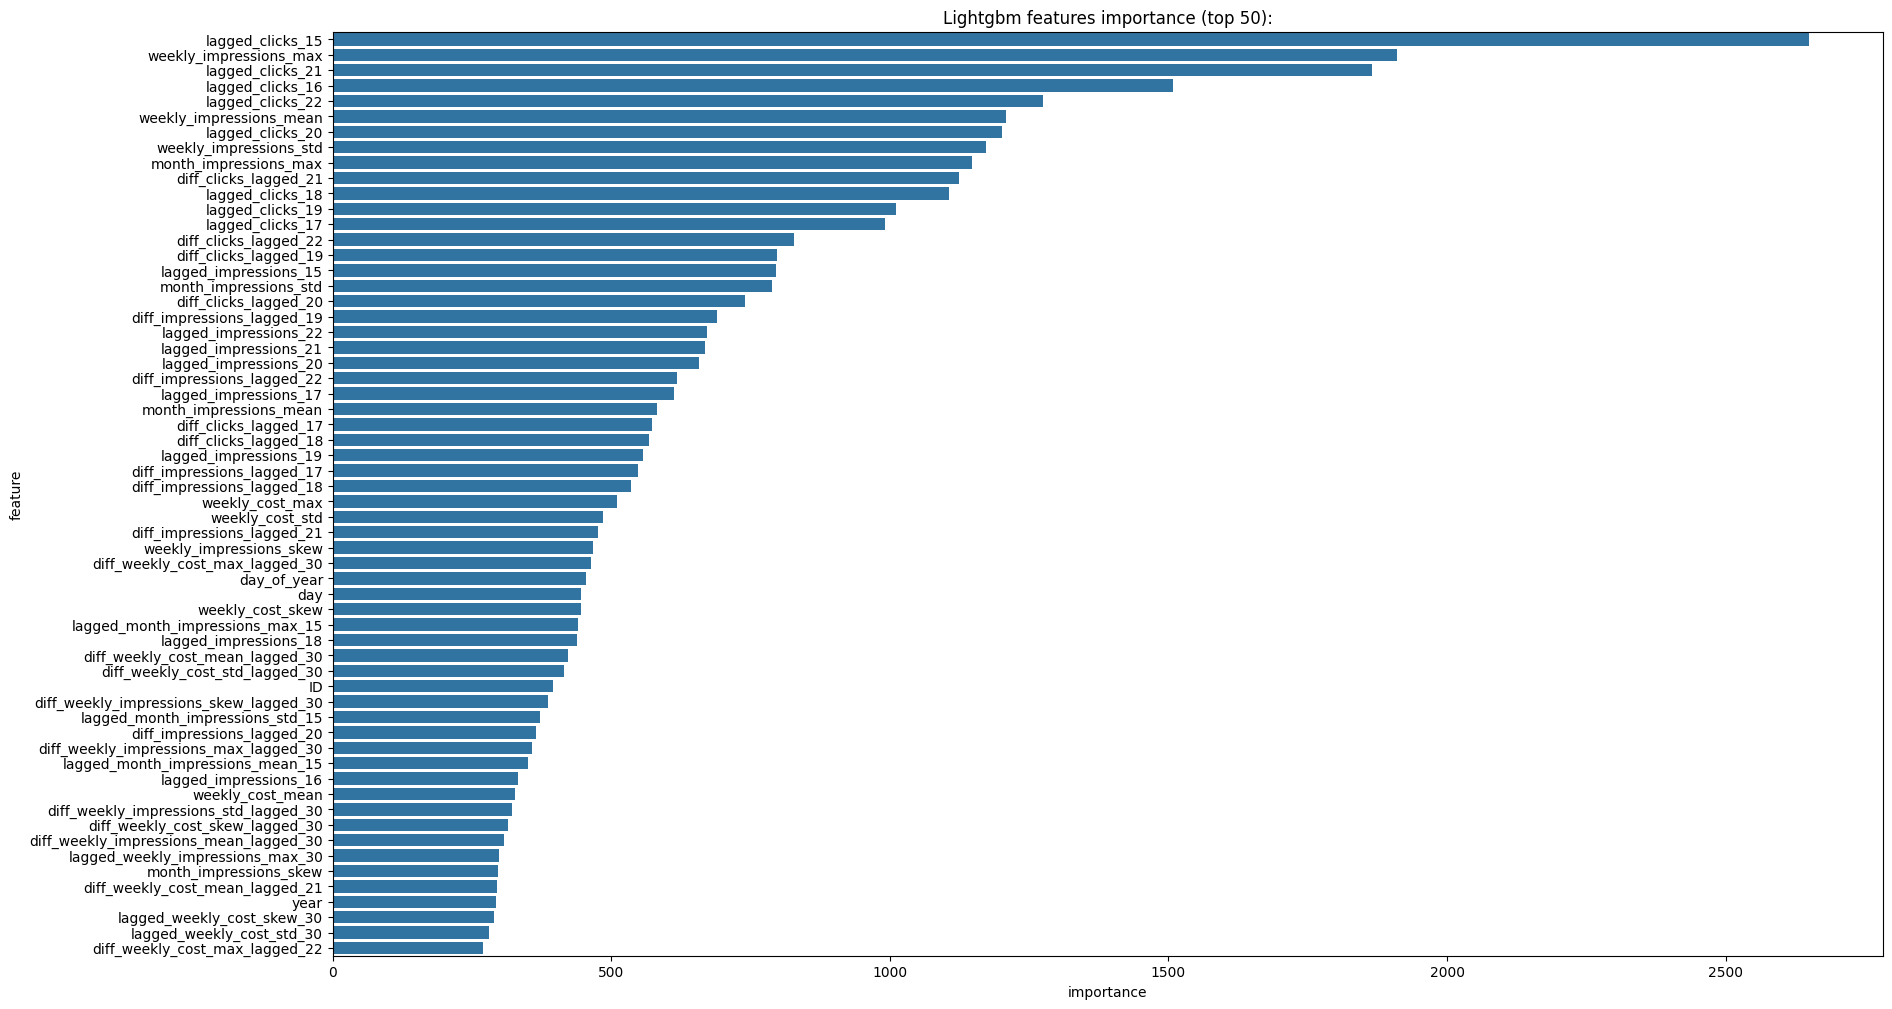

In [20]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('Lightgbm features importance (top 50):')

### Use SHAP to explain the model

In [21]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

In [23]:
shap_values

.values =
array([[ 0.08782363,  0.02971877,  0.12576189, ..., -0.00720723,
         0.46687859, -0.40530261],
       [ 0.06374396,  0.02944759,  0.37109677, ..., -0.00271083,
        -0.09624171,  1.08648452],
       [-0.27259157, -0.04555521, -0.01370966, ..., -0.00237516,
        -0.24623096, -0.13060209],
       ...,
       [-0.03781092, -0.01741561,  0.17178013, ..., -0.00271083,
        -0.05462127,  0.27395426],
       [ 0.4110351 , -0.04766469,  0.09361489, ..., -0.00720723,
         0.19077057,  0.50479312],
       [-0.14894953, -0.1197662 , -0.03593663, ...,  0.00262485,
        -0.15246064, -0.00111453]])

.base_values =
array([32.14231115, 32.14231115, 32.14231115, ..., 32.14231115,
       32.14231115, 32.14231115])

.data =
array([[nan, nan, nan, ..., 0.0, 20077.5, 3.857900823429087],
       [nan, nan, nan, ..., 0.0, 5338.0, 1.2174414799381874],
       [466.0, 476.0, 404.0, ..., 0.0, 5721.0, 1.5730151357054474],
       ...,
       [nan, nan, nan, ..., 0.0, 9431.939153701318

### Submission

In [24]:
preds = np.mean(fold_preds, axis = 0)
final_test_df['preds'] = preds
sub = final_test_df[['unique_id', 'preds']]
sub['unique_id'] = sub['unique_id'].str.replace("-", "_")
sub.to_csv('submission.csv', index=False)